In [1]:
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
idx = pd.IndexSlice
pd.set_option("display.max_rows",101)
pd.set_option('expand_frame_repr', False)
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

# MRChem benchmark calculations

This notebook presents benchmark timings for the MRChem program on a set of molecular calculations using a variable number of CPU cores. The test systems are standard linear alkane chains $C_nH_{2n+2}$, with $n$ ranging from 2 to 350, as well as the Caffeine ($C_{8}H_{10}N_{4}O_{2}$) and Valinomycine ($C_{54}H_{90}N_{6}O_{18}$) molecules. The main purpose of this data is to monitor the development of the code performance between different version, but it will also provide a reference for users to check if the code has been properly installed and runs reasonably on their system. Not all molecular systems will be available in the data, which mirrors the current limitations of the code when it comes to system size and numerical precision. Only a small selection of the data will be presented below, but further details are available by digging into the raw data.

## MRChem SCF cycle

The Self-Consistent Field (SCF) cycle in MRChem contains the following steps:

- Building Fock operator
- Calculating Fock matrix
- Rotating orbitals (diagonalization or localization)
- Calculating SCF energy
- Applying Helmholtz operator
- Applying iterative subspace acceleration (KAIN)

and each of these may have sub steps that can be extracted from the data below. The calculations are performed using one of the following methods:

- Hartree (to show the performance of the backbone SCF algorithm + Coulomb interaction)
- Hartree-Fock (to show the performance of the exact exchange operator)
- DFT-PBE (to show the performance of the density functional integrator)

## Parallel performance

The following table presents timings (in sec) for the different parts of a single SCF cycle for the $C_{10}H_{22}$
molecule at numerical precision $\epsilon=10^{-5}$, using the Hartree method. The calculations are using an increasing number of MPI processes and OMP threads per process. The molecule has 82 electrons and 41 doubly occupied molecular orbitals.

In [111]:
prec=5
molecule='alkane_010'
hybrid_series = pd.read_csv("alkane-Hartree/scf.csv", index_col=[0,1,2,3,4]).loc[molecule,:,:,:]
hybrid_series

Localize  SCF energy  Helmholtz      KAIN  Fock operator  Fock matrix  Total SCF
molecule   prec MPI OMP orbs                                                                                  
alkane_010 5    8   8   41     39.4437     2.90505    62.3098  2.390920        37.5800     10.21140   173.4020
                    16  41     36.5734     1.70633    34.2841  1.808520        22.5300      9.16007   119.8670
                    32  41     40.2007     2.30365    40.2836  1.906690        14.9594     10.24880   123.5550
                16  8   41     27.2695     1.89151    30.9674  1.832570        30.4150      8.52193   113.5150
                    16  41     23.8044     1.55917    17.6612  1.256320        16.4527      7.94105    79.3245
                    32  41     25.0966     1.38045    19.1953  1.326950        13.5627      8.97089    79.8281
                32  8   41     19.8689     1.47236    20.9884  0.807469        35.8510      7.74652   100.5230
                    16  41     17.4656     0.93015    12.3694  0.757378        21.9187      6.09010    69.7208
                    32  41     18.5341     1.18338    10.9720  0.901694        18.5990      5.66938    65.7093

## OpenMP scaling

The following table presents timings (in sec) on a single compute node for the different parts of a single SCF cycle for the $C_{10}H_{22}$ molecule at numerical precision $\epsilon=10^{-5}$, using the Hartree. The molecule has 82 electrons and 41 doubly occupied molecular orbitals.

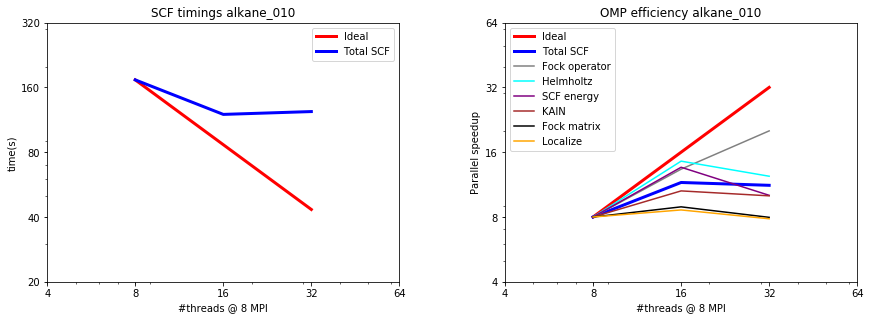

orbs  Localize  SCF energy  Helmholtz     KAIN  Fock operator  Fock matrix  Total SCF
molecule   MPI OMP                                                                                       
alkane_010 8   8      41   39.4437     2.90505    62.3098  2.39092        37.5800     10.21140    173.402
               16     41   36.5734     1.70633    34.2841  1.80852        22.5300      9.16007    119.867
               32     41   40.2007     2.30365    40.2836  1.90669        14.9594     10.24880    123.555

In [125]:
mpi=8
molecule='alkane_010'
omp_frame = pd.read_csv("alkane-Hartree/scf.csv", index_col=[0,1,2])
omp_series = omp_frame.loc[molecule,mpi]

plt.subplot(121)
plt.title('SCF timings ' + molecule)
plt.plot(omp_series.index, mpi*omp_series['Total SCF'][mpi]/omp_series.index, 'red', lw=3, label='Ideal')
plt.plot(omp_series['Total SCF'], 'blue', lw=3, label='Total SCF')
plt.legend(loc='upper right')
plt.yscale('log')
plt.xscale('log')
plt.yticks([20, 40, 80, 160, 320], [20, 40, 80, 160, 320])
plt.xticks([4, 8, 16, 32, 64], [4, 8, 16, 32, 64])
plt.ylabel('time(s)')
plt.xlabel('#threads' + ' @ ' + str(mpi) + ' MPI')

plt.subplot(122)
plt.title('OMP efficiency ' + molecule)
plt.plot(omp_series.index, omp_series.index, 'red', lw=3, label='Ideal')
plt.plot(mpi*omp_series['Total SCF'][mpi]/omp_series['Total SCF'], 'blue', lw=3, label='Total SCF')
plt.plot(mpi*omp_series['Fock operator'][mpi]/omp_series['Fock operator'], c='gray', label='Fock operator')
plt.plot(mpi*omp_series['Helmholtz'][mpi]/omp_series['Helmholtz'], c='cyan', label='Helmholtz')
plt.plot(mpi*omp_series['SCF energy'][mpi]/omp_series['SCF energy'], c='purple', label='SCF energy')
plt.plot(mpi*omp_series['KAIN'][mpi]/omp_series['KAIN'], c='brown', label='KAIN')
plt.plot(mpi*omp_series['Fock matrix'][mpi]/omp_series['Fock matrix'], c='black', label='Fock matrix')
plt.plot(mpi*omp_series['Localize'][mpi]/omp_series['Localize'], c='orange', label='Localize')
plt.legend(loc='upper left')
plt.yscale('log')
plt.xscale('log')
plt.yticks([4, 8, 16, 32, 64], [4, 8, 16, 32, 64])
plt.xticks([4, 8, 16, 32, 64], [4, 8, 16, 32, 64])
plt.ylabel('Parallel speedup')
plt.xlabel('#threads' + ' @ ' + str(mpi) + ' MPI')

plt.subplots_adjust(top=1.0, bottom=0.1, right=2, wspace=.30)
plt.show()
omp_frame.loc[molecule,mpi,:]

## MPI scaling

The following table presents timings (in sec) for the different parts of a single SCF cycle for the $C_{10}H_{22}$
molecule at numerical precision $\epsilon=10^{-5}$, using the Hartree method. The calculations are using an increasing number of MPI processes with fixed a single OMP threads per process. The molecule has 82 electrons and 41 doubly occupied molecular orbitals.

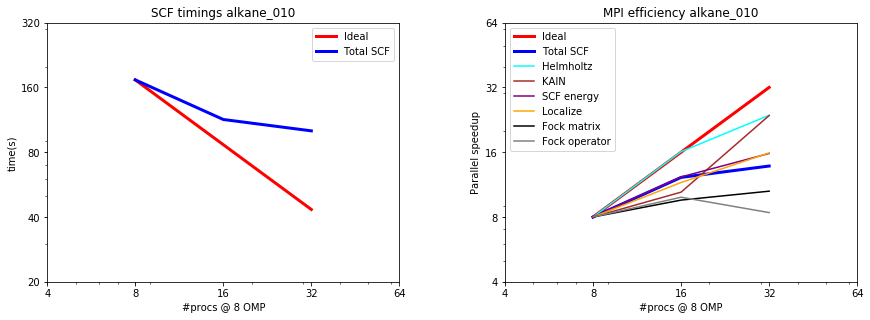

orbs  Localize  SCF energy  Helmholtz      KAIN  Fock operator  Fock matrix  Total SCF
molecule   OMP MPI                                                                                        
alkane_010 8   8      41   39.4437     2.90505    62.3098  2.390920         37.580     10.21140    173.402
               16     41   27.2695     1.89151    30.9674  1.832570         30.415      8.52193    113.515
               32     41   19.8689     1.47236    20.9884  0.807469         35.851      7.74652    100.523

In [133]:
omp=8
ref=8
molecule='alkane_010'
mpi_frame = pd.read_csv("alkane-Hartree/scf.csv", index_col=[0,2,1])
mpi_series = mpi_frame.loc[molecule,omp]

plt.subplot(121)
plt.title('SCF timings ' + molecule)
plt.plot(mpi_series.index, ref*mpi_series['Total SCF'][ref]/mpi_series.index, 'red', lw=3, label='Ideal')
plt.plot(mpi_series['Total SCF'], 'blue', lw=3, label='Total SCF')
plt.legend(loc='upper right')
plt.yscale('log')
plt.xscale('log')
plt.yticks([20, 40, 80, 160, 320], [20, 40, 80, 160, 320])
plt.xticks([4, 8, 16, 32, 64], [4, 8, 16, 32, 64])
plt.ylabel('time(s)')
plt.xlabel('#procs' + ' @ ' + str(omp) + ' OMP')

plt.subplot(122)
plt.title('MPI efficiency ' + molecule)
plt.plot(mpi_series.index, mpi_series.index, c='red', lw=3, label='Ideal')
plt.plot(ref*mpi_series['Total SCF'][ref]/mpi_series['Total SCF'], c='blue', lw=3, label='Total SCF')
plt.plot(ref*mpi_series['Helmholtz'][ref]/mpi_series['Helmholtz'], c='cyan', label='Helmholtz')
plt.plot(ref*mpi_series['KAIN'][ref]/mpi_series['KAIN'], c='brown', label='KAIN')
plt.plot(ref*mpi_series['SCF energy'][ref]/mpi_series['SCF energy'], c='purple', label='SCF energy')
plt.plot(ref*mpi_series['Localize'][ref]/mpi_series['Localize'], c='orange', label='Localize')
plt.plot(ref*mpi_series['Fock matrix'][ref]/mpi_series['Fock matrix'], c='black', label='Fock matrix')
plt.plot(ref*mpi_series['Fock operator'][ref]/mpi_series['Fock operator'], c='gray', label='Fock operator')
plt.legend(loc='upper left')
plt.yscale('log')
plt.xscale('log')
plt.yticks([4, 8, 16, 32, 64], [4, 8, 16, 32, 64])
plt.xticks([4, 8, 16, 32, 64], [4, 8, 16, 32, 64])
plt.ylabel('Parallel speedup')
plt.xlabel('#procs' + ' @ ' + str(omp) + ' OMP')

plt.subplots_adjust(top=1.0, bottom=0.1, right=2, wspace=.30)
plt.show()
mpi_frame.loc[molecule,omp,:]

## Hybrid MPI/OpenMP scaling

The following table presents timings (in sec) for the different parts of a single SCF cycle for the $C_{6}H_{14}$
molecule at numerical precision $\epsilon=10^{-5}$, using the Hartree. The calculations are using an increasing number of MPI processes with fixed 8 OMP threads per process. The molecule has 50 electrons and 25 doubly occupied molecular orbitals.

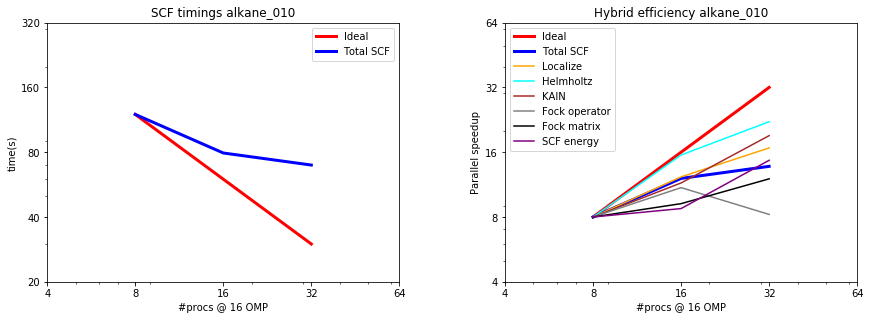

orbs  Localize  SCF energy  Helmholtz      KAIN  Fock operator  Fock matrix  Total SCF
molecule   OMP MPI                                                                                        
alkane_010 16  8      41   36.5734     1.70633    34.2841  1.808520        22.5300      9.16007   119.8670
               16     41   23.8044     1.55917    17.6612  1.256320        16.4527      7.94105    79.3245
               32     41   17.4656     0.93015    12.3694  0.757378        21.9187      6.09010    69.7208

In [135]:
omp=16
ref=8
molecule='alkane_010'
hybrid_frame = pd.read_csv("alkane-Hartree/scf.csv", index_col=[0,2,1])
hybrid_series = hybrid_frame.loc[molecule,omp]

plt.subplot(121)
plt.title('SCF timings ' + molecule)
plt.plot(hybrid_series.index, ref*hybrid_series['Total SCF'][ref]/hybrid_series.index, 'red', lw=3, label='Ideal')
plt.plot(hybrid_series['Total SCF'], 'blue', lw=3, label='Total SCF')
plt.legend(loc='upper right')
plt.yscale('log')
plt.xscale('log')
plt.yticks([20, 40, 80, 160, 320], [20, 40, 80, 160, 320])
plt.xticks([4, 8, 16, 32, 64], [4, 8, 16, 32, 64])
plt.ylabel('time(s)')
plt.xlabel('#procs' + ' @ ' + str(omp) + ' OMP')

plt.subplot(122)
plt.title('Hybrid efficiency ' + molecule)
plt.plot(hybrid_series.index, hybrid_series.index, c='red', lw=3, label='Ideal')
plt.plot(ref*hybrid_series['Total SCF'][ref]/hybrid_series['Total SCF'], c='blue', lw=3, label='Total SCF')
plt.plot(ref*hybrid_series['Localize'][ref]/hybrid_series['Localize'], c='orange', label='Localize')
plt.plot(ref*hybrid_series['Helmholtz'][ref]/hybrid_series['Helmholtz'], c='cyan', label='Helmholtz')
plt.plot(ref*hybrid_series['KAIN'][ref]/hybrid_series['KAIN'], c='brown', label='KAIN')
plt.plot(ref*hybrid_series['Fock operator'][ref]/hybrid_series['Fock operator'], c='gray', label='Fock operator')
plt.plot(ref*hybrid_series['Fock matrix'][ref]/hybrid_series['Fock matrix'], c='black', label='Fock matrix')
plt.plot(ref*hybrid_series['SCF energy'][ref]/hybrid_series['SCF energy'], c='purple', label='SCF energy')
plt.legend(loc='upper left')
plt.yscale('log')
plt.xscale('log')
plt.yticks([4, 8, 16, 32, 64], [4, 8, 16, 32, 64])
plt.xticks([4, 8, 16, 32, 64], [4, 8, 16, 32, 64])
plt.ylabel('Parallel speedup')
plt.xlabel('#procs' + ' @ ' + str(omp) + ' OMP')

plt.subplots_adjust(top=1.0, bottom=0.1, right=2, wspace=.30)
plt.show()
mpi_frame.loc[molecule,omp,:]

## System scaling

The following table presents timings (in sec) for the different parts of a single SCF cycle for the $C_{n}H_{2n+2}$
linear alkanes at numerical precision $\epsilon=10^{-5}$, using the Hartree method. The calculations are using a fixed number of MPI processes and OMP threads per process. The molecule has 50 electrons and 25 doubly occupied molecular orbitals.

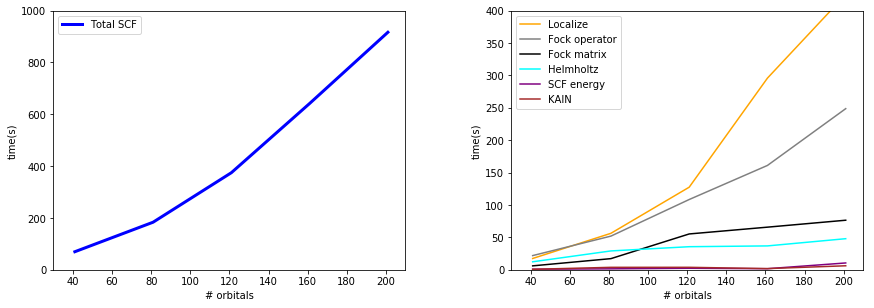

,molecule,Localize,SCF energy,Helmholtz,KAIN,Fock operator,Fock matrix,Total SCF
orbs,,,,,,,,
41,alkane_010,17.4656,0.93015,12.3694,0.757378,21.9187,6.0901,69.7208
81,alkane_020,56.3228,1.48507,29.1243,3.812960,51.9998,17.2398,183.6410
121,alkane_030,127.4820,2.34472,35.6503,3.835250,108.4700,55.3250,374.6460
161,alkane_040,295.8220,1.68921,36.8670,1.857980,161.0540,65.8045,641.6900
201,alkane_050,424.7600,10.55510,48.0092,6.202200,248.6810,76.5107,916.4310


In [139]:
omp=16
mpi=32
mol_frame = pd.read_csv("alkane-Hartree/scf.csv", index_col=[1,2,3])
mol_series = mol_frame.loc[mpi,omp]

plt.subplot(121)
plt.plot(mol_series['Total SCF'], 'blue', lw=3, label='Total SCF')
plt.legend(loc='upper left')
plt.axis([30, 210, 0, 1000])
plt.ylabel('time(s)')
plt.xlabel('# orbitals')

plt.subplot(122)
plt.plot(mol_series['Localize'], 'orange', label='Localize')
plt.plot(mol_series['Fock operator'], 'gray', label='Fock operator')
plt.plot(mol_series['Fock matrix'], 'black', label='Fock matrix')
plt.plot(mol_series['Helmholtz'], 'cyan', label='Helmholtz')
plt.plot(mol_series['SCF energy'], 'purple', label='SCF energy')
plt.plot(mol_series['KAIN'], 'brown', label='KAIN')
plt.legend(loc='upper left')
plt.axis([30, 210, 0, 400])
plt.ylabel('time(s)')
plt.xlabel('# orbitals')

plt.subplots_adjust(top=1.0, bottom=0.1, right=2, wspace=.30)
plt.show()
mol_frame.loc[mpi,omp,:]

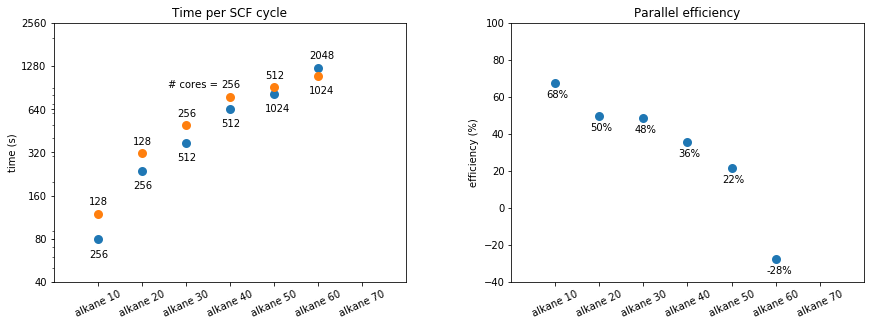

In [60]:
omp = 16
mol_frame = pd.read_csv("alkane-Hartree/scf.csv", index_col=[2,1,3])
mol_series = mol_frame.loc[omp]
mol   = ['alkane 10','alkane 20','alkane 30','alkane 40','alkane 50','alkane 60', 'alkane 70']
idx   = [   1,   2,   3,   4,   5,   6, 7]
orbs  = [  41,  81, 121, 161, 201, 241]
t_1   = [   0,   0,   0,   0,   0,   0]
t_2   = [   0,   0,   0,   0,   0,   0]
mpi_1 = [   8,   8,  16,  16,  32,  64]
mpi_2 = [  16,  16,  32,  32,  64, 128]
cpu_1 = [ 128, 128, 256, 256, 512,1024]
cpu_2 = [ 256, 256, 512, 512,1024,2048]
eff   = [   1,   1,   1,   1,   1,   1]
time  = [  40,  80, 160, 320, 640, 1280, 2560]
for i in range(0, len(orbs)):
    t_1[i] = mol_frame['Total SCF'].loc[omp, mpi_1[i], orbs[i]]
    t_2[i] = mol_frame['Total SCF'].loc[omp, mpi_2[i], orbs[i]]
    eff[i] = 100*(mpi_2[i]/mpi_1[i]) * (t_1[i] - t_2[i])/t_1[i]
    #print(str(orbs[i]) + ' : ' + str(mpi_1[i]) + ' ' + str(t_1[i]) + '   ' + str(mpi_2[i]) + ' ' + str(t_2[i]) + '   ' + str(eff[i]))

plt.subplot(121)
plt.title('Time per SCF cycle')
plt.scatter(idx[:-1], t_2, lw=3)
plt.scatter(idx[:-1], t_1, lw=3)
plt.axis([0, 8, 40, 2560])
plt.yscale('log')
plt.yticks(time, time)
plt.xticks(idx, mol, rotation=25)
plt.ylabel('time (s)')
plt.annotate("# cores =", (2.6, 900))
for i, txt in enumerate(cpu_1):
    shift = 1.15
    if i == 5:
        shift = 0.75
    plt.annotate(txt, (idx[i]-0.2, t_1[i]*shift))
for i, txt in enumerate(cpu_2):
    shift = 0.75
    if i == 5:
        shift = 1.15
    plt.annotate(txt, (idx[i]-0.2, t_2[i]*shift))

plt.subplot(122)
plt.title('Parallel efficiency')
plt.scatter(idx[:-1], eff, lw=3)
plt.axis([0, 8, -40, 100])
plt.xticks(idx, mol, rotation=25)
plt.ylabel('efficiency (%)')
for i, txt in enumerate(eff):
    plt.annotate('{:2.0f}%'.format(txt), (idx[i]-0.2, eff[i]-8))


plt.subplots_adjust(top=1.0, bottom=0.1, right=2, wspace=.30)
plt.show()